In [17]:
class Config:#resize images
    IMAGE_WIDTH = 256  
    IMAGE_HEIGHT = 256 
    CHANNELS = 3  


import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



image_width = Config.IMAGE_WIDTH  
image_height = Config.IMAGE_HEIGHT 


image_filenames_train = []
mask_files = glob('kaggle_3m/*/*_mask*')
for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

RecursionError: maximum recursion depth exceeded in comparison

In [5]:

image_width = Config.IMAGE_WIDTH  
image_height = Config.IMAGE_HEIGHT 


image_filenames_train = []
mask_files = glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train) 


['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']


3929

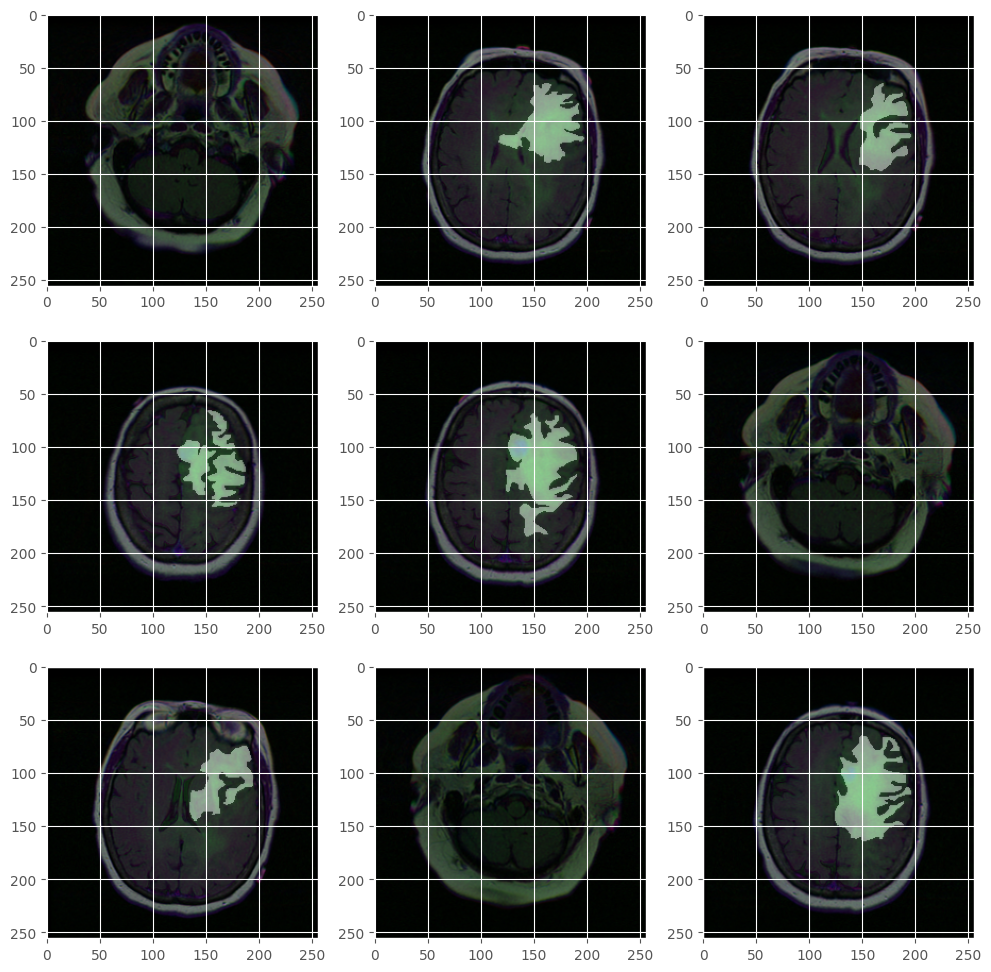

None


In [6]:
#helper functions
def visualize_image_mask(rows, columns, image_paths, mask_paths):
    fig = plt.figure(figsize=(12, 12))
    for idx in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, idx)
        current_image_path = image_paths[idx]
        current_mask_path = mask_paths[idx]
        img = cv2.imread(current_image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        overlay_mask = cv2.imread(current_mask_path)
        plt.imshow(img)
        plt.imshow(overlay_mask, alpha=0.4)
    plt.show()

def dice_score(true_labels, predicted_labels, smoothing_factor=100):
    flattened_true = tf.keras.backend.flatten(true_labels)
    flattened_predicted = tf.keras.backend.flatten(predicted_labels)

    overlap = tf.keras.backend.sum(flattened_true * flattened_predicted)
    total_area = tf.keras.backend.sum(flattened_true) + tf.keras.backend.sum(flattened_predicted)
    return (2 * overlap + smoothing_factor) / (total_area + smoothing_factor)

def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)

def intersection_over_union(true_labels, predicted_labels, smoothing_factor=100):
    overlap = tf.keras.backend.sum(true_labels * predicted_labels)
    combined_area = tf.keras.backend.sum(true_labels + predicted_labels)
    iou_score = (overlap + smoothing_factor) / (combined_area - overlap + smoothing_factor)
    return iou_score

print(visualize_image_mask(3, 3 , image_filenames_train, mask_files ))

In [7]:
# Create a DataFrame with image and mask paths
dataset = pd.DataFrame(data={'image_paths': image_filenames_train, 'mask_paths': mask_files})

# Shuffle the dataset
df = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=42)

# Further split training data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Print proportions of each split
print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

train_data.shape
test_data.shape
val_data.shape

Training set: 2828 samples
Validation set: 708 samples
Test set: 393 samples


(708, 2)

In [ ]:
print(df.head())

In [8]:
def data_generator(
    image_paths_df,
    batch_size,
    aug_params,
    img_color_mode="rgb",
    msk_color_mode="grayscale",
    img_prefix="aug_image",
    msk_prefix="aug_mask",
    output_dir=None,
    img_size=(256, 256),
    random_seed=1,
):
    """
    Generates batches of images and masks with the same transformations applied.
    """
    img_gen = ImageDataGenerator(**aug_params)
    msk_gen = ImageDataGenerator(**aug_params)

    img_data_gen = img_gen.flow_from_dataframe(
        image_paths_df,
        x_col="image_paths",
        class_mode=None,
        color_mode=img_color_mode,
        target_size=img_size,
        batch_size=batch_size,
        save_to_dir=output_dir,
        save_prefix=img_prefix,
        seed=random_seed,
    )

    msk_data_gen = msk_gen.flow_from_dataframe(
        image_paths_df,
        x_col="mask_paths",
        class_mode=None,
        color_mode=msk_color_mode,
        target_size=img_size,
        batch_size=batch_size,
        save_to_dir=output_dir,
        save_prefix=msk_prefix,
        seed=random_seed,
    )

    combined_gen = zip(img_data_gen, msk_data_gen)

    for (img, mask) in combined_gen:
        img, mask = normalize_and_diagnose(img, mask)
        # Optionally visualize the augmentations
        # visualize_augmentations(img[0], mask[0])
        yield (img, mask)


In [9]:
def normalize_and_diagnose(img, mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [10]:
epochs = 100
batch_size = 32
learning_rate = 1e-4
smooth = 100

In [11]:
#referred code....

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Dropout,
    Lambda,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    concatenate,
)

from tensorflow.keras import backend as K


def unet(input_size=(256, 256, 3)):
    
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

RecursionError: maximum recursion depth exceeded in comparison

In [12]:
model = unet()
model.summary()

NameError: name 'unet' is not defined

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, batch_size,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, batch_size,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999,amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / batch_size, 
                    epochs=epochs, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / batch_size)

#instead of running code for 100 epochs i have included pre trained model

2.17.0


NameError: name 'load_model' is not defined

2.17.0
